<a href="https://colab.research.google.com/github/LeeYoungJun1113/Thesis___/blob/main/K_THESIS_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

## 내 드라이브에 코랩이 호환 하게함

Mounted at /content/gdrive


In [7]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.1 MB/s 


In [9]:
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from nibabel.testing import data_path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from IPython.display import clear_output
import cv2
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


Version:  2.8.2
Eager mode:  True
GPU is available


In [13]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
#from keras.optimizer_v2 import adam
from tensorflow.keras.optimizers import Adam


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
import segmentation_models as sm



In [4]:
example_ni1 = os.path.join(data_path, 'example4d.nii.gz')
n1_img = nib.load(example_ni1)
n1_img

In [5]:
raw_data = pd.read_csv('/content/gdrive/MyDrive/K_THESIS/input/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/gdrive/MyDrive/K_THESIS/input/covid19-ct-scans/',regex=True)
raw_data.head(5)
#raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...
1,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...
2,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...
3,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...
4,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...,/content/gdrive/MyDrive/K_THESIS/input/covid19...


In [6]:
raw_data.shape

(20, 4)

In [7]:

def read_nii(filepath):
  ct_scan = nib.load(filepath)
  array = ct_scan.get_fdata()
  array = np.rot90(np.array(array))
  return(array)


In [8]:
# Read sample
sample_ct = read_nii(raw_data.loc[0,'ct_scan'])
sample_lung = read_nii(raw_data.loc[0, 'lung_mask'])
sample_infe = read_nii(raw_data.loc[0, 'infection_mask'])
sample_all = read_nii(raw_data.loc[0, 'lung_and_infection_mask'])

In [16]:
sample_lung.shape

(512, 512, 301)

In [10]:
# Lets inspect the images, as well as annotations that I have available;

def plot_sample(array_list, color_map = 'nipy_spectral'):
  fig = plt.figure(figsize=(18, 15))

  plt.subplot(1,4,1)
  plt.imshow(array_list[0], cmap='bone')
  plt.title('Original Image')

  plt.subplot(1,4,2)
  plt.imshow(array_list[0], cmap='bone')
  plt.imshow(array_list[1], alpha=0.5, cmap='bone')
  plt.title('Lung Mask')

  plt.subplot(1,4,3)
  plt.imshow(array_list[0], cmap='bone')
  plt.imshow(array_list[2], alpha=0.5, cmap='bone')
  plt.title('Infection Mask')


  plt.subplot(1,4,4)
  plt.imshow(array_list[0], cmap='bone')
  plt.imshow(array_list[3], alpha=0.5, cmap='bone')
  plt.title('Lung and Infection Mask')

  plt.show()


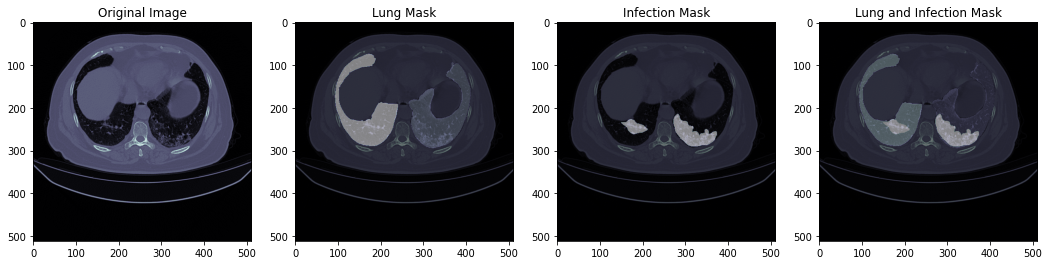

In [11]:
# Examine one slice of a ct scan and its annotations.
plot_sample([sample_ct[...,100], sample_lung[...,100], sample_infe[...,100], sample_all[...,100]])

In [13]:
def bulk_plot_sample(array_list, index_list):
  for index_value in index_list:
    plot_sample([array_list[0][...,index_value], array_list[1][...,index_value],
                 array_list[2][...,index_value], array_list[3][...,index_value]])

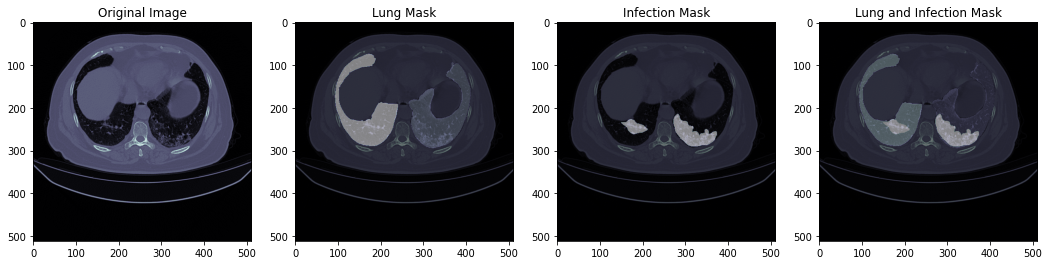

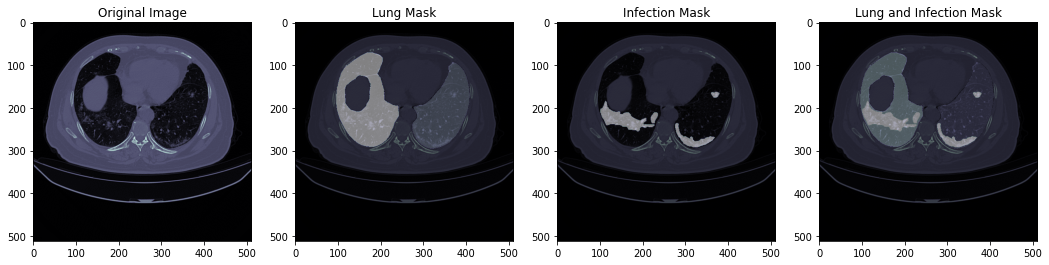

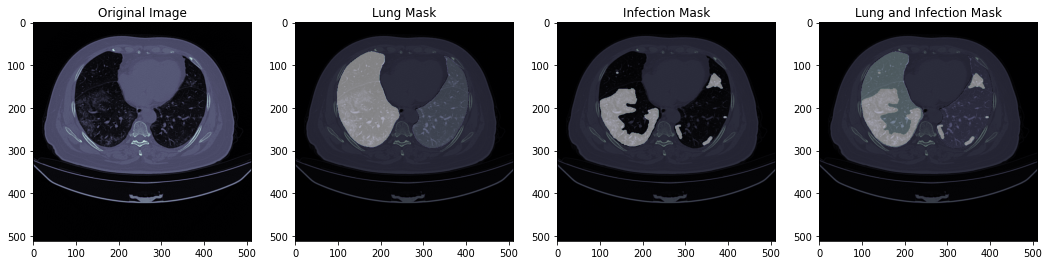

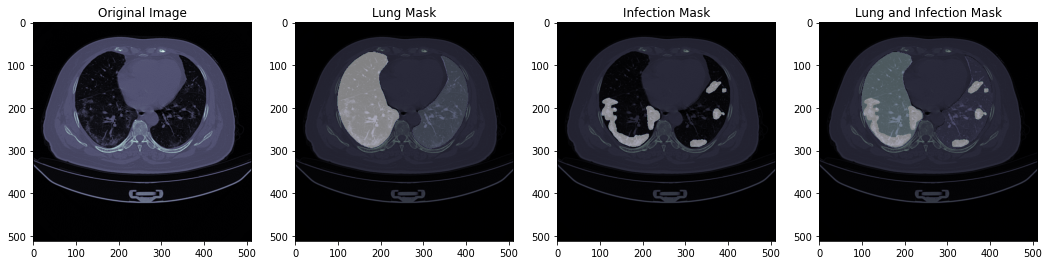

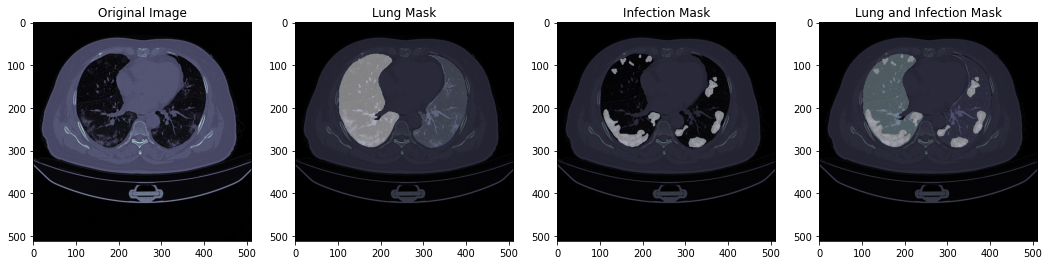

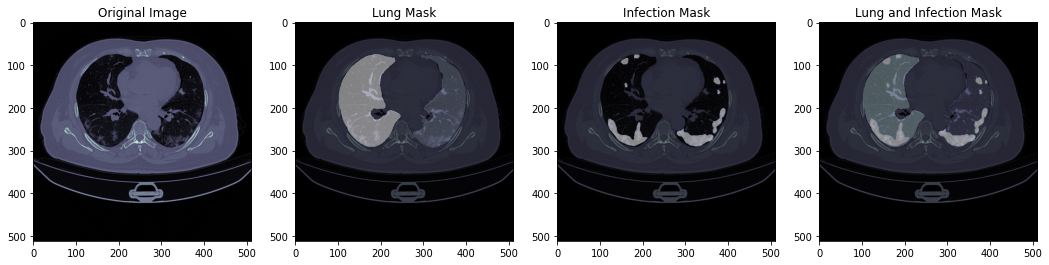

In [14]:
bulk_plot_sample([sample_ct, sample_lung, sample_infe, sample_all], 
                 index_list=[100,110,120,130,140,150])